In [6]:
from torchvision.datasets import VOCDetection
from PIL import Image, ImageDraw, ImageFont
from torchvision.transforms.functional import to_tensor, to_pil_image
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import numpy as np
import xml.etree.ElementTree as ET
import collections
from typing import Dict, Any

# import albumentations as A
# from albumentations.pytorch import ToTensor
import os
path2data = '/home/ljj0512/private/dataset/voc_2007'
if not os.path.exists(path2data):
    os.mkdir(path2data)

classes = [
    "aeroplane",
    "bicycle",
    "bird",
    "boat",
    "bottle",
    "bus",
    "car",
    "cat",
    "chair",
    "cow",
    "diningtable",
    "dog",
    "horse",
    "motorbike",
    "person",
    "pottedplant",
    "sheep",
    "sofa",
    "train",
    "tvmonitor"
]

class myVOCDetection(VOCDetection):
    def __getitem__(self, index):
        img = np.array(Image.open(self.images[index]).convert('RGB'))
        target = self.parse_voc_xml(ET.parse(self.annotations[index]).getroot()) # xml파일 분석하여 dict으로 받아오기
        print('self.annotation[index] :',self.annotations[index])
        targets = [] # 바운딩 박스 좌표
        labels = [] # 바운딩 박스 클래스

        # 바운딩 박스 정보 받아오기
        for t in target['annotation']['object']:
            label = np.zeros(5)
            label[:] = t['bndbox']['xmin'], t['bndbox']['ymin'], t['bndbox']['xmax'], t['bndbox']['ymax'], classes.index(t['name'])

            targets.append(list(label[:4])) # 바운딩 박스 좌표
            labels.append(label[4])         # 바운딩 박스 클래스

        if self.transforms:
            augmentations = self.transforms(image=img, bboxes=targets)
            img = augmentations['image']
            targets = augmentations['bboxes']

        return img, targets, labels

    def parse_voc_xml(self, node: ET.Element) -> Dict[str, Any]: # xml 파일을 dictionary로 반환
        voc_dict: Dict[str, Any] = {}
        children = list(node)
        if children:
            def_dic: Dict[str, Any] = collections.defaultdict(list)
            for dc in map(self.parse_voc_xml, children):
                for ind, v in dc.items():
                    def_dic[ind].append(v)
            if node.tag == "annotation":
                def_dic["object"] = [def_dic["object"]]
            voc_dict = {node.tag: {ind: v[0] if len(v) == 1 else v for ind, v in def_dic.items()}}
        if node.text:
            text = node.text.strip()
            if not children:
                voc_dict[node.tag] = text
        return voc_dict



In [12]:
train_ds = myVOCDetection(path2data, year='2007', image_set='train', download=True)
print(len(train_ds))
val_ds = myVOCDetection(path2data, year='2007', image_set='test', download=True)
print(len(val_ds))

Using downloaded and verified file: /home/ljj0512/private/dataset/voc_2007/VOCtrainval_06-Nov-2007.tar
Extracting /home/ljj0512/private/dataset/voc_2007/VOCtrainval_06-Nov-2007.tar to /home/ljj0512/private/dataset/voc_2007
2501
Using downloaded and verified file: /home/ljj0512/private/dataset/voc_2007/VOCtest_06-Nov-2007.tar
Extracting /home/ljj0512/private/dataset/voc_2007/VOCtest_06-Nov-2007.tar to /home/ljj0512/private/dataset/voc_2007
4952


2501
self.annotation[index] : /home/ljj0512/private/dataset/voc_2007/VOCdevkit/VOC2007/Annotations/000012.xml
<class 'numpy.ndarray'>
(333, 500, 3)


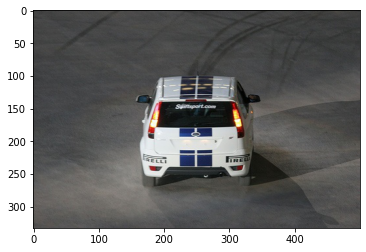

[156.0, 97.0, 351.0, 270.0]
[6.0]



In [13]:
import matplotlib.pyplot as plt
# 샘플 이미지 확인
print(len(train_ds))
img, target, label = train_ds[0]
print(type(img))
print(img.shape)
plt.imshow(img)
plt.show()

for i in range(len(target)):
    print(target[i])
print(label)
print()
# print(target.shape)


colors = np.random.randint(0, 255, size=(80,3), dtype='uint8') # 바운딩 박스 색상

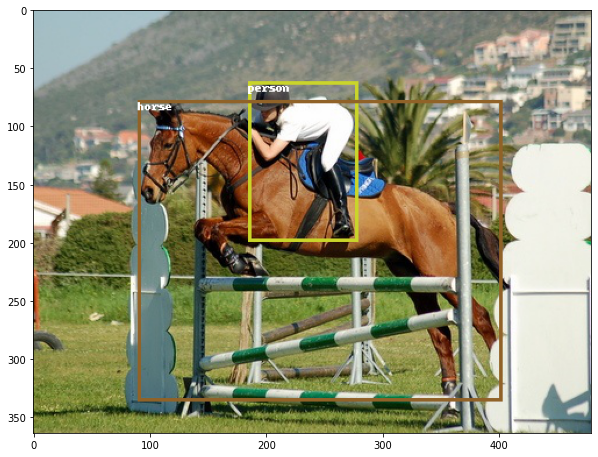

In [12]:
import matplotlib.pyplot as plt
# 샘플 이미지 확인
img, target, label = train_ds[1]
colors = np.random.randint(0, 255, size=(80,3), dtype='uint8') # 바운딩 박스 색상

# 시각화 함수
def show(img, targets, labels, classes=classes):
    img = to_pil_image(img)
    draw = ImageDraw.Draw(img)
    targets = np.array(targets)
    W, H = img.size

    for tg,label in zip(targets,labels):
        id_ = int(label) # class
        bbox = tg[:4]    # [x1, y1, x2, y2]

        color = [int(c) for c in colors[id_]]
        name = classes[id_]

        draw.rectangle(((bbox[0], bbox[1]), (bbox[2], bbox[3])), outline=tuple(color), width=3)
        draw.text((bbox[0], bbox[1]), name, fill=(255,255,255,0))
    plt.imshow(np.array(img))

plt.figure(figsize=(10,10))
show(img, target, label)

In [ ]:
# import albumentations as A

# # transforms 정의
# IMAGE_SIZE = 600
# scale = 1.0

# # 이미지에 padding을 적용하여 종횡비를 유지시키면서 크기가 600x600 되도록 resize 합니다.
# train_transforms = A.Compose([
#                     A.LongestMaxSize(max_size=int(IMAGE_SIZE * scale)),
#                     A.PadIfNeeded(min_height=int(IMAGE_SIZE*scale), min_width=int(IMAGE_SIZE*scale),border_mode=cv2.BORDER_CONSTANT),
#                     ToTensor()
#                     ],
#                     bbox_params=A.BboxParams(format='pascal_voc', min_visibility=0.4, label_fields=[])
#                     )

# val_transforms = A.Compose([
#                     A.LongestMaxSize(max_size=int(IMAGE_SIZE * scale)),
#                     A.PadIfNeeded(min_height=int(IMAGE_SIZE*scale), min_width=int(IMAGE_SIZE*scale),border_mode=cv2.BORDER_CONSTANT),
#                     ToTensor()
#                     ],
#                     bbox_params=A.BboxParams(format='pascal_voc', min_visibility=0.4, label_fields=[])
#                     )

# # transforms 적용하기
# train_ds.transforms = train_transforms
# val_ds.transforms = val_transforms

In [16]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
# import cv2

DEVICE = torch.device('cuda:2')

model = torchvision.models.vgg16(pretrained=True).to(DEVICE)
print(model.features)
features = list(model.features)

# only collect layers with output feature map size (W, H) < 50
dummy_img = torch.zeros((1, 3, 800, 800)).float() # test image array

req_features = []
output = dummy_img.clone().to(DEVICE)

# for feature in features:
#     output = feature(output)
# #     print(output.size()) => torch.Size([batch_size, channel, width, height])
#     if output.size()[2] < 800//16: # 800/16=50
#         break
#     req_features.append(feature)
#     out_channels = output.size()[1]

# faster_rcnn_feature_extractor = nn.Sequential(*req_features)

# output_map = faster_rcnn_feature_extractor(imgTensor)


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [17]:
"""" Anchor generation layer """"

feature_size = 800 // 16  # = 50
ctr_x = np.arange(16, (feature_size + 1) * 16, 16)  
ctr_y = np.arange(16, (feature_size + 1) * 16, 16)
print(ctr_x[0:5])

ratios = [0.5, 1, 2]
scales = [8, 16, 32]
sub_sample = 16

# 각 픽셀에 대한 anchor boxe
anchor_boxes = np.zeros(((feature_size * feature_size * 9), 4)) # anchor box개수, anchor box 좌표
print(anchor_boxes.shape)
index = 0

for c in zip(ctr_y, ctr_x):                        # per anchors
    ctr_y, ctr_x = c
    for i in range(len(ratios)):     # per ratios
        for j in range(len(scales)): # per scales
            
            # anchor box height, width
            h = sub_sample * scales[j] * np.sqrt(ratios[i])
            w = sub_sample * scales[j] * np.sqrt(1./ ratios[i])
            
            # anchor box [x1, y1, x2, y2]
            anchor_boxes[index, 1] = ctr_y - h / 2.
            anchor_boxes[index, 0] = ctr_x - w / 2.
            anchor_boxes[index, 3] = ctr_y + h / 2.
            anchor_boxes[index, 2] = ctr_x + w / 2.
            index += 1

[16 32 48 64 80]
(22500, 4)


In [ ]:
"""" Anchor target layer """"
